# Manipular dados para a previsão de AVC

---

### Informações
Este projeto tem como objetivo analisar e manipular dados de pacientes e desenvolver modelo de aprendizado de máquina para prever o evento de AVC em novos pacientes.

O arquivo está organizado conforme etapas de um projeto de ciência de dados e desenvolvimento de modelos de aprendizado de máquina.

O projeto tem como base o estudo de caso do curso Formação Inteligência Artificial Aplicada a Medicia da Data Science Academy.


## Carregar pacotes

In [85]:
# Info do sistema
import os

# Manipular dados e computação científica
import pandas as pd
import numpy as np

# Salvar arquivos
import pickle

# métricas para avaliação dos modelos
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve

# Dividir dados treino e teste
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style = "whitegrid")

# não mostrar avisos
import warnings
warnings.filterwarnings('ignore')

# ------------------------------ Etapa 1 ------------------------------ 

### Informações sobre o problema
O Acidente Vascular Cerebral (AVC) acontece quando vasos que levam sangue ao cérebro entopem ou se rompem, provocando a paralisia da área cerebral que ficou sem circulação sanguínea. É uma doença que acomete mais os homens e é uma das principais causas de morte, incapacitação e internações em todo o mundo.

Quanto mais rápido for o diagnóstico e o tratamento do AVC, maiores serão as chances de recuperação completa. Desta forma, torna-se primordial ficar atento aos sinais e sintomas e procurar atendimento médico imediato.

Existem dois tipos de AVC, que ocorrem por motivos diferentes: AVC hemorrágico e AVC isquêmico.

Existem diversos fatores que aumentam a probabilidade de ocorrência de um AVC, seja ele hemorrágico ou isquêmico. Os principais fatores causais das doenças são:

- Hipertensão;
- Diabetes tipo 2;
- Colesterol alto;
- Sobrepeso;
- Obesidade;
- Tabagismo;
- Uso excessivo de álcool;
- Idade avançada;
- Sedentarismo;
- Uso de drogas ilícitas;
- Histórico familiar;
- Ser do sexo masculino.

O AVC está altamente relacionado à idade, hipertensão, nível médio de glicose, status de tabagismo e IMC, enquanto isso depende parcialmente do sexo, doença cardíaca, tipo de trabalho e tipo de residência.


### Objetivo
Prever a ocorrência de AVC.


### Métodos
Métodos de classificação binária para prever a ocorrência de AVC.


#### Métrica
AUC Score (Area Under The Curve Score), cujo valor vai de 1 a 100% e para esse problema o valor da métrica deve ser aproximadamente de 99%, uma vez que a previsão do modelo está relacionada a casos de vida ou morte.

# ------------------------------ Etapa 2 ------------------------------ 
## Compreensão dos dados

In [2]:
# Definir diretório dos dados
#print(os.getcwd())

In [3]:
path = '..\_dados\PrevendoAVC'
os.chdir(path)

In [4]:
# Carregar dados
df = pd.read_csv('dataset_avc.csv')

In [5]:
# Visualizar informações básicas
print("Dimensões do dataset \n", 
      "Número de observações (linhas):", 
      df.shape[0], 
      "\n Número de variáveis (colunas): ",
      df.shape[1])
df.head()

Dimensões do dataset 
 Número de observações (linhas): 43400 
 Número de variáveis (colunas):  12


,id,sexo,idade,hipertensao,doenca_coracao,casado,tipo_trabalho,tipo_residencia,media_nivel_glicose,imc,status_tabagismo,avc
0,30669,Masculino,3.0,0,0,No,crianca,Rural,95.12,18.0,NaN,0
1,30468,Masculino,58.0,1,0,Yes,Privado,Urbana,87.96,39.2,nunca fumou,0
2,16523,Feminino,8.0,0,0,No,Privado,Urbana,110.89,17.6,NaN,0
3,56543,Feminino,70.0,0,0,Yes,Privado,Rural,69.04,35.9,fuma eventualmente,0
4,46136,Masculino,14.0,0,0,No,Nunca_trabalhou,Rural,161.28,19.1,NaN,0


Variável target encontra-se na última coluna: 'avc'

In [6]:
# Valores em cada classe da variável target
df['avc'].value_counts()

0    42617
1      783
Name: avc, dtype: int64

0: sem AVC | 1: com AVC

In [7]:
# Tipos de dados
df.dtypes

id                       int64
sexo                    object
idade                  float64
hipertensao              int64
doenca_coracao           int64
casado                  object
tipo_trabalho           object
tipo_residencia         object
media_nivel_glicose    float64
imc                    float64
status_tabagismo        object
avc                      int64
dtype: object

# ------------------------------ Etapa 3 ------------------------------ 
## Preparação dos dados

### Identificar e remover colunas irrelevantes

In [8]:
del df['id'], df['casado']

In [9]:
df.describe()

,idade,hipertensao,doenca_coracao,media_nivel_glicose,imc,avc
count,43400.000000,43400.000000,43400.000000,43400.000000,41938.000000,43400.000000
mean,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,22.519649,0.291235,0.212733,43.111751,7.770020,0.133103
min,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,24.000000,0.000000,0.000000,77.540000,23.200000,0.000000
50%,44.000000,0.000000,0.000000,91.580000,27.700000,0.000000
75%,60.000000,0.000000,0.000000,112.070000,32.900000,0.000000
max,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


In [10]:
# Extrair variáveis do tipo categóricas
df_cat_name = df.dtypes[df.dtypes == 'object'].index

# Extrair variáveis do tipo contínuas
df_con_name = [i for i in list(df.columns) if i not in list(df_cat_name)]

In [11]:
# Visualizar variáveis categóricas
df[df_cat_name].describe()

,sexo,tipo_trabalho,tipo_residencia,status_tabagismo
count,43400,43400,43400,30108
unique,3,5,2,3
top,Feminino,Privado,Urbana,nunca fumou
freq,25665,24834,21756,16053


### Tratar valores missing na variável contínua IMC

In [12]:
print('Número total de valores missing: ',df['imc'].isnull().sum())
df['imc'].describe()

Número total de valores missing:  1462


count    41938.000000
mean        28.605038
std          7.770020
min         10.100000
25%         23.200000
50%         27.700000
75%         32.900000
max         97.600000
Name: imc, dtype: float64

#### Maneiras de tratar valores missing:
- remover linhas
- inputar zero, valore centrais ou estatisticamente estimados no lugar dos valores missing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E4CCF4A9B0>]],
      dtype=object)

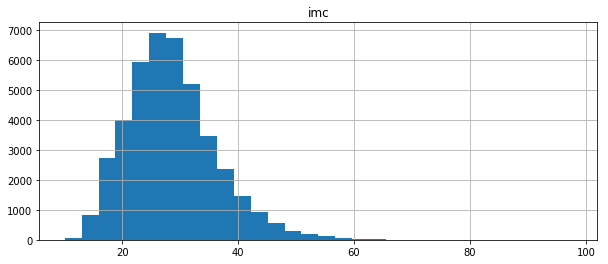

In [13]:
# Verificar distribuição
df.hist(column='imc', figsize=(10,4), bins=30)

O valor de IMC entre 20 e 40 é o mais comum, portanto, não é totalmente irracional utilizá-lo no lugar de valores missing.

Inputar a tendência central (média) no lugar dos valores missing.

In [14]:
# Onde for nulo, preenche com a média, senão, mantemos o valor atual.
imc = np.where(df['imc'].isnull(), df['imc'].mean(), df['imc'])
imc

array([18. , 39.2, 17.6, ..., 28.9, 33.2, 20.6])

In [15]:
df['imc'] = imc

Número total de valores missing:  0
count    43400.000000
mean        28.605038
std          7.638023
min         10.100000
25%         23.400000
50%         28.100000
75%         32.600000
max         97.600000
Name: imc, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E4CD15EBE0>]],
      dtype=object)

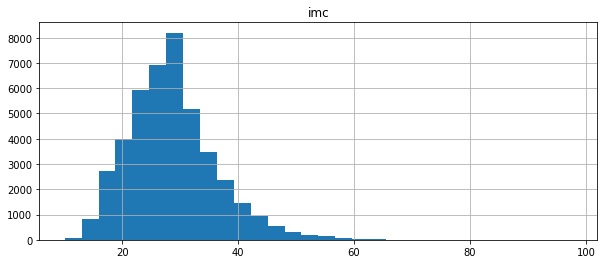

In [16]:
# Verificar novamente valores missing 
print('Número total de valores missing: ',df['imc'].isnull().sum())
print(df['imc'].describe())
df.hist(column='imc', figsize=(10,4), bins=30)

### Tratar valores missing na variável categórica Status de Tabagismo

Número total de valores missing:  13292
count           30108
unique              3
top       nunca fumou
freq            16053
Name: status_tabagismo, dtype: object


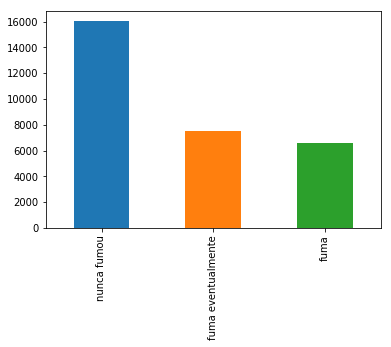

In [21]:
print('Número total de valores missing: ',df['status_tabagismo'].isnull().sum())
print(df['status_tabagismo'].describe())
df['status_tabagismo'].value_counts().plot(kind='bar')

Preencher os valores missing com uma nova categoria: "desconhecido".

In [22]:
status_tab_desconhecido = np.where(df['status_tabagismo'].isnull(), "desconhecido", df['status_tabagismo'])
df['status_tabagismo'] = status_tab_desconhecido

Número total de valores missing:  0
count           43400
unique              4
top       nunca fumou
freq            16053
Name: status_tabagismo, dtype: object


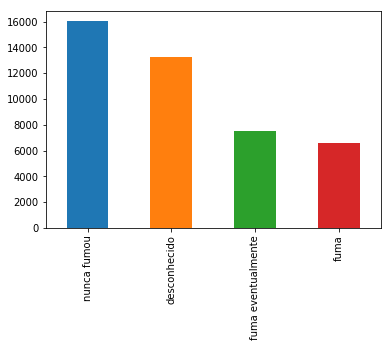

In [23]:
print('Número total de valores missing: ',df['status_tabagismo'].isnull().sum())
print(df['status_tabagismo'].describe())
df['status_tabagismo'].value_counts().plot(kind='bar')

In [24]:
# Verificar se há mais valores missing em outras variáveis
df.count()

sexo                   43400
idade                  43400
hipertensao            43400
doenca_coracao         43400
tipo_trabalho          43400
tipo_residencia        43400
media_nivel_glicose    43400
imc                    43400
status_tabagismo       43400
avc                    43400
dtype: int64

### Tratar outliers

In [25]:
df[df_con_name].describe()

,idade,hipertensao,doenca_coracao,media_nivel_glicose,imc,avc
count,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000,43400.000000
mean,42.217894,0.093571,0.047512,104.482750,28.605038,0.018041
std,22.519649,0.291235,0.212733,43.111751,7.638023,0.133103
min,0.080000,0.000000,0.000000,55.000000,10.100000,0.000000
25%,24.000000,0.000000,0.000000,77.540000,23.400000,0.000000
50%,44.000000,0.000000,0.000000,91.580000,28.100000,0.000000
75%,60.000000,0.000000,0.000000,112.070000,32.600000,0.000000
max,82.000000,1.000000,1.000000,291.050000,97.600000,1.000000


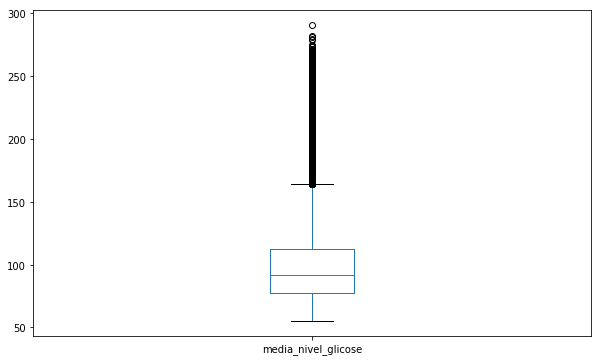

In [28]:
# Variável media_nivel_glicose
df['media_nivel_glicose'].plot(kind="box", figsize=(10,6))

In [29]:
# Identificar outliers
outliers_index = np.where(df['media_nivel_glicose'] == max(df['media_nivel_glicose']))

In [30]:
df.loc[outliers_index]

,sexo,idade,hipertensao,doenca_coracao,tipo_trabalho,tipo_residencia,media_nivel_glicose,imc,status_tabagismo,avc
38446,Feminino,80.0,0,0,Privado,Rural,291.05,28.7,nunca fumou,0


In [31]:
# Excluir outlier
df = df.drop(outliers_index[0])

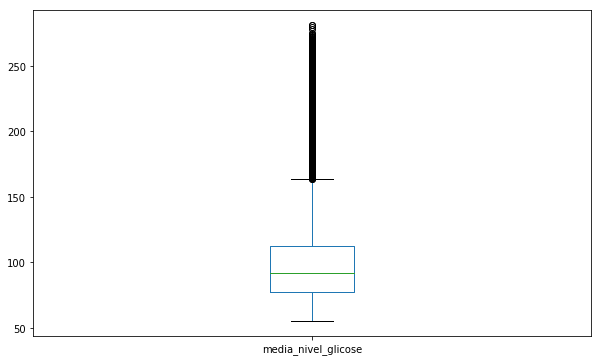

In [32]:
df['media_nivel_glicose'].plot(kind="box", figsize=(10,6))

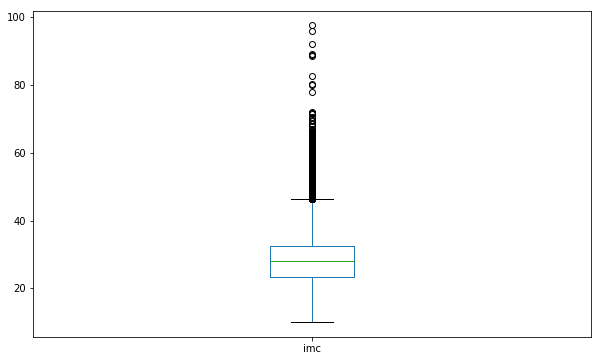

In [33]:
# Variável media_nivel_glicose
df['imc'].plot(kind="box", figsize=(10,6))

O valor do IMC pode chegar ao máximo de até 54, o que também é um caso muito raro. Opção escolida é remover valores acima de 60.

In [34]:
df = df[df['imc'] < 60]

In [35]:
print(df.count())
df.describe()

sexo                   43309
idade                  43309
hipertensao            43309
doenca_coracao         43309
tipo_trabalho          43309
tipo_residencia        43309
media_nivel_glicose    43309
imc                    43309
status_tabagismo       43309
avc                    43309
dtype: int64


,idade,hipertensao,doenca_coracao,media_nivel_glicose,imc,avc
count,43309.000000,43309.00000,43309.000000,43309.000000,43309.000000,43309.000000
mean,42.213087,0.09326,0.047542,104.442117,28.526248,0.018079
std,22.533671,0.29080,0.212798,43.060134,7.438084,0.133240
min,0.080000,0.00000,0.000000,55.000000,10.100000,0.000000
25%,24.000000,0.00000,0.000000,77.540000,23.400000,0.000000
50%,44.000000,0.00000,0.000000,91.570000,28.000000,0.000000
75%,60.000000,0.00000,0.000000,112.030000,32.600000,0.000000
max,82.000000,1.00000,1.000000,281.590000,59.900000,1.000000


### Converter variáveis categóricas em valores numéricos

In [36]:
df['sexo'].unique()

array(['Masculino', 'Feminino', 'Outro'], dtype=object)

In [37]:
df['tipo_residencia'].unique()

array(['Rural', 'Urbana'], dtype=object)

In [40]:
df['sexo'] = df['sexo'].astype('category')
df['tipo_residencia'] = df['tipo_residencia'].astype('category')

df['sexo'] = df['sexo'].cat.codes
df['tipo_residencia'] = df['tipo_residencia'].cat.codes

In [42]:
# Converter variáveis com mais de 3 categorias
df = pd.get_dummies(df, columns = ['tipo_trabalho','status_tabagismo'], prefix = ["trabalho",'tabagismo'])

In [43]:
df.head()

,sexo,idade,hipertensao,doenca_coracao,tipo_residencia,media_nivel_glicose,imc,avc,trabalho_Autonomo,trabalho_Nunca_trabalhou,trabalho_Privado,trabalho_Servidor_Publico,trabalho_crianca,tabagismo_desconhecido,tabagismo_fuma,tabagismo_fuma eventualmente,tabagismo_nunca fumou
0,1,3.0,0,0,0,95.12,18.0,0,0,0,0,0,1,1,0,0,0
1,1,58.0,1,0,1,87.96,39.2,0,0,0,1,0,0,0,0,0,1
2,0,8.0,0,0,1,110.89,17.6,0,0,0,1,0,0,1,0,0,0
3,0,70.0,0,0,0,69.04,35.9,0,0,0,1,0,0,0,0,1,0
4,1,14.0,0,0,0,161.28,19.1,0,0,1,0,0,0,1,0,0,0


# ------------------------------ Etapa 4 ------------------------------ 
## Construção do Modelo

### Dividir dados em dados de treino e teste

In [44]:
# Dividir dados em X e Y
X = df.loc[:, df.columns != 'avc']
Y = df['avc']

In [45]:
# Parâmetros para a divisão dos dados em treino e teste
seed = 7
test_size = 0.33

In [47]:
# Dividir dados em dados de treino e dados de teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, Y, test_size = test_size, random_state = seed)

In [49]:
# Dimensões das dados criados
print("X Treino: ", X_treino.shape[0])
print("X Teste: ", X_teste.shape[0])

print("Y Treino: ", y_treino.shape[0])
print("Y Teste: ", y_teste.shape[0])

X Treino:  29017
X Teste:  14292
Y Treino:  29017
Y Teste:  14292


### Construção dos Modelos

In [78]:
# Funções auxiliares para calcular métricas de avaliação do modelo

# Gerar relatório de métricas
def print_report(y_atual, y_pred, thresh):
    
    auc = roc_auc_score(y_atual, y_pred)
    accuracy = accuracy_score(y_atual, (y_pred > thresh))
    
    print('AUC: %.3f' %auc)
    print('Acurácia: %.3f' %accuracy)
    
    return auc,accuracy

In [79]:
thresh=0.5

## Modelos

In [80]:
# Modelo 1 - Regressão Logística
lr = LogisticRegression(random_state=123)

model_v1 = lr.fit(X_treino, y_treino)

y_treino_pred = lr.predict_proba(X_treino)[:,1]
y_teste_pred = lr.predict_proba(X_teste)[:,1]

lr_report_treino = []
lr_report_valid = []
print('----- Regressão Logística -----')
print('Treinamento')
lr_report_treino = print_report(y_treino, y_treino_pred, thresh)
print('\nTeste')
lr_report_valid = print_report(y_teste, y_teste_pred, thresh)

# Modelo 2 - Regressão Logística
nb = GaussianNB()

model_v2 = nb.fit(X_treino, y_treino)

y_treino_pred = nb.predict_proba(X_treino)[:,1]
y_teste_pred = nb.predict_proba(X_teste)[:,1]

nb_report_treino = []
nb_report_valid = []

print('\n----- Naive Bayes -----')
print('Treinamento')
nb_report_treino = print_report(y_treino, y_treino_pred, thresh)
print('\nTeste')
nb_report_valid = print_report(y_teste, y_teste_pred, thresh)


# Modelo 3 - XGBC
xgbc = XGBClassifier()

model_v3 = xgbc.fit(X_treino, y_treino)

y_treino_pred = xgbc.predict_proba(X_treino)[:,1]
y_teste_pred = xgbc.predict_proba(X_teste)[:,1]

xgbc_report_treino = []
xgbc_report_valid = []

print('\n----- Xtreme Gradient Boosting Classifier -----')
print('Treinamento')
xgbc_report_treino = print_report(y_treino, y_treino_pred, thresh)
print('\nTeste')
xgbc_report_valid = print_report(y_teste, y_teste_pred, thresh)

# Modelo 4 - Random Forest
rf = RandomForestClassifier()

model_v4 = rf.fit(X_treino, y_treino)

y_treino_pred = rf.predict_proba(X_treino)[:,1]
y_teste_pred = rf.predict_proba(X_teste)[:,1]

rf_report_treino = []
rf_report_valid = []

print('\n----- Random Forest Classifier -----')
print('Treinamento')
rf_report_treino = print_report(y_treino, y_treino_pred, thresh)
print('\nTeste')
rf_report_valid = print_report(y_teste, y_teste_pred, thresh)

----- Regressão Logística -----
Treinamento
AUC: 0.853
Acurácia: 0.981

Teste
AUC: 0.849
Acurácia: 0.983

----- Naive Bayes -----
Treinamento
AUC: 0.828
Acurácia: 0.386

Teste
AUC: 0.829
Acurácia: 0.380

----- Xtreme Gradient Boosting Classifier -----
Treinamento
AUC: 0.888
Acurácia: 0.981

Teste
AUC: 0.856
Acurácia: 0.983

----- Random Forest Classifier -----
Treinamento
AUC: 1.000
Acurácia: 0.996

Teste
AUC: 0.645
Acurácia: 0.982


# ------------------------------ Etapa 5 ------------------------------ 
## Avaliação e Interpretação

In [81]:
df_results = pd.DataFrame({
    'classificador':['RL','RL','NB','NB','XGB','XGB','RF','RF'],
    'data_set':['treino','validação']*4,
    'auc': [lr_report_treino[0], lr_report_valid[0], nb_report_treino[0], nb_report_valid[0], xgbc_report_treino[0], xgbc_report_valid[0],rf_report_treino[0], rf_report_valid[0]],
    'accuracy': [lr_report_treino[1], lr_report_valid[1], nb_report_treino[1], nb_report_valid[1], xgbc_report_treino[1], xgbc_report_valid[1],rf_report_treino[1], rf_report_valid[1]],
    
})

### Comparar métrica AUC

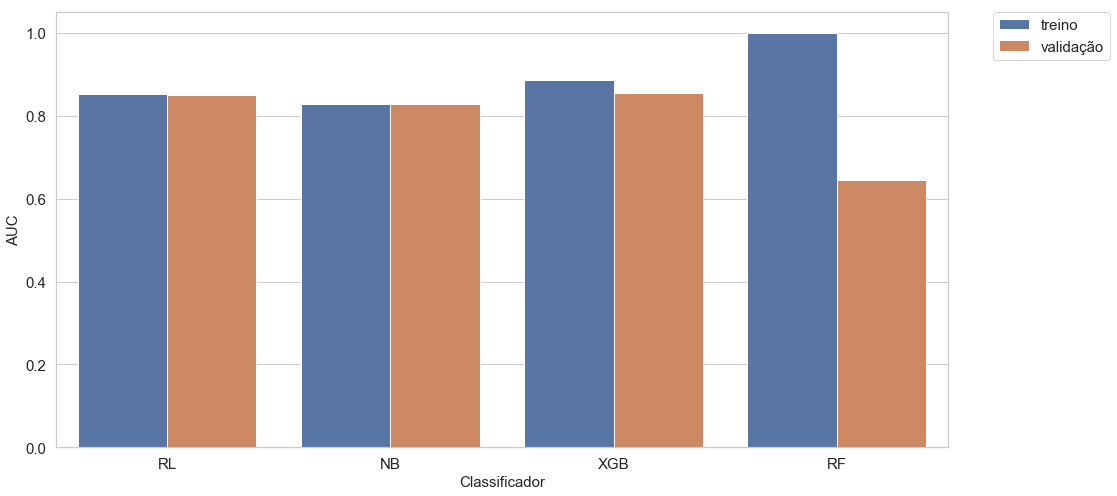

In [86]:
plt.figure(figsize=(16,8))

ax = sns.barplot(x='classificador',y='auc',hue='data_set',data=df_results)
ax.set_xlabel('Classificador', fontsize=15)
ax.set_ylabel('AUC', fontsize=15)
ax.tick_params(labelsize=15)

# Legenda
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., fontsize = 15)

### Comparar métrica Acurácia

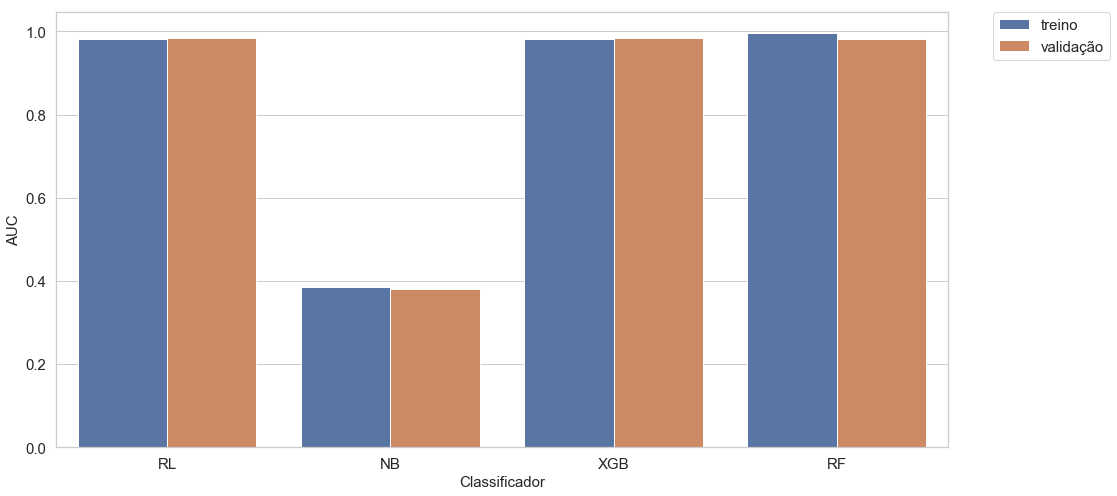

In [87]:
plt.figure(figsize=(16,8))

ax = sns.barplot(x='classificador',y='accuracy',hue='data_set',data=df_results)
ax.set_xlabel('Classificador', fontsize=15)
ax.set_ylabel('AUC', fontsize=15)
ax.tick_params(labelsize=15)

# Legenda
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., fontsize = 15)

### Salvar modelo escolhido

In [89]:
#os.getcwd()

In [90]:
path = '..\..\PrevendoAVC\modelos'
os.chdir(path)

In [92]:
model_v4

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [93]:
# De acordo com a AUC Score, o melhor modelo é o v3
pickle.dump(model_v4, open('best_model.pkl','wb'), protocol=4)

### Avaliar Modelo

In [94]:
# Carregar modelo
best_model = pickle.load(open('best_model.pkl','rb'))

In [96]:
# Calcular probabilidades de previsão
y_treino_pred = best_model.predict_proba(X_treino)[:,1]
y_teste_pred = best_model.predict_proba(X_teste)[:,1]

In [101]:
# Desempenho
thresh = 0.5

print('\nTreinamento:')
report_treino = []
report_treino = print_report(y_treino, y_treino_pred, thresh)


print('\nTeste:')
report_teste = []
report_teste = print_report(y_teste, y_teste_pred, thresh)


Treinamento:
AUC: 1.000
Acurácia: 0.996

Teste:
AUC: 0.645
Acurácia: 0.982


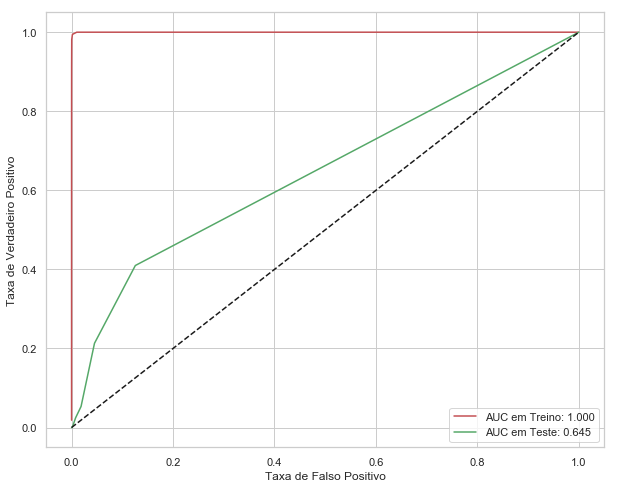

In [102]:
# Calcula a curva ROC nos dados de treino
fpr_train, tpr_train, thresholds_train = roc_curve(y_treino, y_treino_pred)
auc_train = roc_auc_score(y_treino, y_treino_pred)


# Calcula a curva ROC nos dados de teste
fpr_test, tpr_test, thresholds_test = roc_curve(y_teste, y_teste_pred)
auc_test = roc_auc_score(y_teste, y_teste_pred)

# Plot
plt.figure(figsize=(10,8))
plt.plot(fpr_train, tpr_train, 'r-',label ='AUC em Treino: %.3f'%auc_train)
plt.plot(fpr_test, tpr_test, 'g-',label ='AUC em Teste: %.3f'%auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.legend()
plt.show()

# ------------------------------ Etapa 6 ------------------------------ 
## Deploy 

In [103]:
path = '..\..\_dados\PrevendoAVC'
os.chdir(path)

In [129]:
# Carregando dados de um novo paciente
novos_dados = pd.read_csv('dataset_avc_novos_pacientes.csv')

In [130]:
print(novos_dados.shape)
novos_dados.head()

(18601, 11)


,id,sexo,idade,hipertensao,doenca_coracao,casado,tipo_trabalho,tipo_residencia,media_nivel_glicose,imc,status_tabagismo
0,36306,Masculino,80.0,0,0,Yes,Privado,Urbano,83.84,21.1,fuma eventualmente
1,61829,Feminino,74.0,0,1,Yes,Autonomo,Rural,179.50,26.0,fuma eventualmente
2,14152,Feminino,14.0,0,0,No,crianca,Rural,95.16,21.2,NaN
3,12997,Masculino,28.0,0,0,No,Privado,Urbano,94.76,23.4,NaN
4,40801,Feminino,63.0,0,0,Yes,Servidor_Publico,Rural,83.57,27.6,nunca fumou


### Aplicar tratamentos aos novos dados

In [131]:
# Deletar variáveis não utilizadas
del novos_dados['casado']

# Tratar variável status_tabagismo
novo_status_tabagismo = np.where(novos_dados['status_tabagismo'].isnull(), 
                                 "desconhecido", 
                                 novos_dados['status_tabagismo'])
novos_dados['status_tabagismo'] = novo_status_tabagismo


In [132]:
# Verificar dados missing
novos_dados.isnull().any()

id                     False
sexo                   False
idade                  False
hipertensao            False
doenca_coracao         False
tipo_trabalho          False
tipo_residencia        False
media_nivel_glicose    False
imc                     True
status_tabagismo       False
dtype: bool

In [133]:
# Tratar dados missing da variável 'imc'
novos_dados['imc'] = np.where(novos_dados['imc'].isnull(), 
                    novos_dados['imc'].mean(), 
                    novos_dados['imc'])

In [135]:
# Tipos de dados
novos_dados.dtypes

id                       int64
sexo                    object
idade                  float64
hipertensao              int64
doenca_coracao           int64
tipo_trabalho           object
tipo_residencia         object
media_nivel_glicose    float64
imc                    float64
status_tabagismo        object
dtype: object

In [136]:
# Tranformar variáveis categóricas
novos_dados['sexo'] = novos_dados['sexo'].astype('category')
novos_dados['tipo_residencia'] = novos_dados['tipo_residencia'].astype('category')
novos_dados['sexo'] = novos_dados['sexo'].cat.codes
novos_dados['tipo_residencia'] = novos_dados['tipo_residencia'].cat.codes
novos_dados = pd.get_dummies(novos_dados, columns = ['tipo_trabalho','status_tabagismo'], prefix = [ "trabalho",'tabagismo'])

In [137]:
novos_dados.dtypes

id                                int64
sexo                               int8
idade                           float64
hipertensao                       int64
doenca_coracao                    int64
tipo_residencia                    int8
media_nivel_glicose             float64
imc                             float64
trabalho_Autonomo                 uint8
trabalho_Never_worked             uint8
trabalho_Privado                  uint8
trabalho_Servidor_Publico         uint8
trabalho_crianca                  uint8
tabagismo_desconhecido            uint8
tabagismo_fuma                    uint8
tabagismo_fuma eventualmente      uint8
tabagismo_nunca fumou             uint8
dtype: object

In [139]:
# Separando a coluna id para usarmos mais tarde
X_novos_dados = novos_dados.loc[:, novos_dados.columns != 'id']
paciente_id = novos_dados['id']

### Prever com novos dados

In [140]:
# Usando dados de teste para as previsões
y_novos_dados_label = best_model.predict(X_novos_dados)
y_novos_dados_prob = best_model.predict_proba(X_novos_dados)

In [141]:
y_novos_dados_label

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [142]:
y_novos_dados_prob

array([[1. , 0. ],
       [0.7, 0.3],
       [1. , 0. ],
       ...,
       [0.9, 0.1],
       [1. , 0. ],
       [1. , 0. ]])

In [143]:
# Extraindo todas as previsões

# Cria um vetor vazio
y_novos_dados = [None] * len(X_novos_dados)

# Looop pelas previsões e gravações no vetor de previsões
for i in range(len(X_novos_dados)):
    y_novos_dados[i] = y_novos_dados_prob[i]

In [144]:
# Vetor de previsões
y_novos_dados[:5]

[array([1., 0.]),
 array([0.7, 0.3]),
 array([1., 0.]),
 array([1., 0.]),
 array([1., 0.])]

In [147]:
# Salvando o resultado com as previsões para cada paciente
resultado = pd.DataFrame()
resultado['id'] = paciente_id
resultado['avc'] = y_novos_dados
print(resultado.shape)
resultado.head()
#resultado.to_csv('dados/resultado.csv', index = False)

(18601, 2)


,id,avc
0,36306,"[1.0, 0.0]"
1,61829,"[0.7, 0.3]"
2,14152,"[1.0, 0.0]"
3,12997,"[1.0, 0.0]"
4,40801,"[1.0, 0.0]"
